# Import packages and libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyLDAvis

In [ ]:
pip install numpy==1.19.2

  Using cached numpy-1.19.2-cp37-cp37m-manylinux2010_x86_64.whl (14.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.2 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.7 which is incompatible.


In [ ]:
pip install pandas==1.1.0

  Using cached pandas-1.1.0-cp37-cp37m-manylinux1_x86_64.whl (10.5 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.2
    Uninstalling pandas-1.3.2:
      Successfully uninstalled pandas-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.2 which is incompatible.
pyldavis 3.3.1 requires pandas>=1.2.0, but you have pandas 1.1.0 which is incompatible.


In [ ]:
pip install folium==0.2.1

In [ ]:
pip install imgaug==0.2.7

In [ ]:
pip install gensim

In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not',
                   'would', 'say', 'could', '_', 'be', 'know', 'good',
                   'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice',
                   'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot',
                   'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                   'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/YouTube-Project/data-youtube-comments.csv')
# df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)
df.head()

(76667, 7)


,channel,name,comment,date,year,time,likes
0,Simplilearn,Simplilearn,"🔥 Enroll for FREE Machine Learning Course &amp; Get your Completion Certificate: <a href=""https:...",26-03-2021,2021,10:21:58,4
1,Simplilearn,Garde Tanmay,"can I please get the datasets my email is tanmaygarde36@<a href=""http://gmail.com/"">gmail.com</a>",20-06-2021,2021,16:23:47,0
2,Simplilearn,Simplilearn,"Hi, thanks for watching our video. We have sent the requested dataset to your mail ID. Do show y...",20-06-2021,2021,18:33:08,0
3,Simplilearn,Nirbhay Kumar,"Great video , May I request data set at reach2nirbhay@<a href=""http://gmail.com/"">gmail.com</a>,...",20-06-2021,2021,09:22:56,1
4,Simplilearn,Simplilearn,"Hi, thanks for watching our video. We have sent the requested dataset to your mail ID. Do show y...",20-06-2021,2021,18:33:13,0


# Pre-processing

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.comment.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation','on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['enroll', 'for', 'free', 'machine', 'learning', 'course', 'amp', 'get', 'your', 'completion', 'certificate', 'href', 'https', 'www', 'simplilearn', 'com', 'learn', 'machine', 'learning', 'basics', 'skillup', 'utm_campaign', 'machinelearning', 'amp', 'utm_medium', 'comment', 'amp', 'utm_source', 'youtube', 'https', 'www', 'simplilearn', 'com', 'learn', 'machine', 'learning', 'basics', 'skillup', 'utm_campaign', 'machinelearning', 'amp', 'utm_medium', 'comment', 'amp', 'utm_source', 'youtube']]


# Build the Bigram, Trigram Models and Lemmatize

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
!python3 -m spacy download en

     |████████████████████████████████| 12.0 MB 11.8 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

# Build the Topic Model

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())

[(0,
  '0.153*"great" + 0.023*"decision_tree" + 0.020*"explanation" + '
  '0.019*"visual" + 0.014*"much" + 0.012*"really" + 0.012*"tutorial" + '
  '0.007*"help" + 0.007*"awesome" + 0.007*"api"'),
 (1,
  '0.606*"video" + 0.296*"show" + 0.003*"watch" + 0.002*"enterprise" + '
  '0.002*"com" + 0.002*"support" + 0.001*"love" + 0.000*"request" + '
  '0.000*"youtube" + 0.000*"alien"'),
 (2,
  '0.413*"learning" + 0.411*"deep" + 0.024*"tell" + 0.019*"explain" + '
  '0.008*"analytic" + 0.004*"sql" + 0.004*"datum" + 0.003*"machine" + '
  '0.002*"simple" + 0.002*"statistic"'),
 (3,
  '0.035*"probability" + 0.035*"distribution" + 0.034*"regression" + '
  '0.034*"correlation" + 0.022*"multiple" + 0.018*"test" + '
  '0.013*"convolutional" + 0.011*"vector" + 0.010*"quot" + 0.008*"base"')]


# Dominant topic and its percentage contribution in each document

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

# Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.5037,"learning, deep, tell, explain, analytic, sql, datum, machine, simple, statistic","[enroll, free, machine, learn, course, simplilearn, com, learn, machine, learning, machinelearne..."
1,1,0.0,0.6794,"great, decision_tree, explanation, visual, much, really, tutorial, help, awesome, api","[dataset, email, href, http, gmail, com, gmail, com]"
2,2,1.0,0.8454,"video, show, watch, enterprise, com, support, love, request, youtube, alien","[watch, video, send, request, dataset, mail, show, love, subscribe, channel, com, youtube, com, ..."
3,3,0.0,0.4154,"great, decision_tree, explanation, visual, much, really, tutorial, help, awesome, api","[great, video, request, datum, set, href, http, gmail, com, gmail, com]"
4,4,1.0,0.8454,"video, show, watch, enterprise, com, support, love, request, youtube, alien","[watch, video, send, request, dataset, mail, show, love, subscribe, channel, com, youtube, com, ..."
5,5,0.0,0.7639,"great, decision_tree, explanation, visual, much, really, tutorial, help, awesome, api","[great, tutorial, send, dataset, tutorial, href, http, gmail, com, gmail, com]"
6,6,1.0,0.8454,"video, show, watch, enterprise, com, support, love, request, youtube, alien","[watch, video, send, request, dataset, mail, show, love, subscribe, channel, com, youtube, com, ..."
7,7,2.0,0.5284,"learning, deep, tell, explain, analytic, sql, datum, machine, simple, statistic","[possible, dataset, implement, code, advance]"
8,8,0.0,0.9262,"great, decision_tree, explanation, visual, much, really, tutorial, help, awesome, api","[view, tutorial, helpful, provide, email, send, request, dataset, promptly, chance, email, hope,..."
9,9,0.0,0.7127,"great, decision_tree, explanation, visual, much, really, tutorial, help, awesome, api","[amazing, tutorial, simplilearn, help, dataset, outlook, com, outlook, com]"


# Most representative sentence for each topic

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.5037,"learning, deep, tell, explain, analytic, sql, datum, machine, simple, statistic","[enroll, free, machine, learn, course, simplilearn, com, learn, machine, learning, machinelearne..."
1,1,0.0,0.6795,"great, decision_tree, explanation, visual, much, really, tutorial, help, awesome, api","[dataset, email, href, http, gmail, com, gmail, com]"
2,2,1.0,0.8454,"video, show, watch, enterprise, com, support, love, request, youtube, alien","[watch, video, send, request, dataset, mail, show, love, subscribe, channel, com, youtube, com, ..."
3,3,0.0,0.4154,"great, decision_tree, explanation, visual, much, really, tutorial, help, awesome, api","[great, video, request, datum, set, href, http, gmail, com, gmail, com]"
4,4,1.0,0.8454,"video, show, watch, enterprise, com, support, love, request, youtube, alien","[watch, video, send, request, dataset, mail, show, love, subscribe, channel, com, youtube, com, ..."
5,5,0.0,0.7639,"great, decision_tree, explanation, visual, much, really, tutorial, help, awesome, api","[great, tutorial, send, dataset, tutorial, href, http, gmail, com, gmail, com]"
6,6,1.0,0.8454,"video, show, watch, enterprise, com, support, love, request, youtube, alien","[watch, video, send, request, dataset, mail, show, love, subscribe, channel, com, youtube, com, ..."
7,7,2.0,0.5284,"learning, deep, tell, explain, analytic, sql, datum, machine, simple, statistic","[possible, dataset, implement, code, advance]"
8,8,0.0,0.9262,"great, decision_tree, explanation, visual, much, really, tutorial, help, awesome, api","[view, tutorial, helpful, provide, email, send, request, dataset, promptly, chance, email, hope,..."
9,9,0.0,0.7127,"great, decision_tree, explanation, visual, much, really, tutorial, help, awesome, api","[amazing, tutorial, simplilearn, help, dataset, outlook, com, outlook, com]"


In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9514,"great, decision_tree, explanation, visual, much, really, tutorial, help, awesome, api","[research, paper, isbell, reading, paper, rish, isbell, reading, paper, rish, academia, document..."
1,1.0,0.9674,"video, show, watch, enterprise, com, support, love, request, youtube, alien","[com, watch, com, watch, com, watch, com, watch, com, watch, com, watch, com, watch, com, watch,..."
2,2.0,0.9731,"learning, deep, tell, explain, analytic, sql, datum, machine, simple, statistic","[step, understand, learning, teaching, learn, relentlessly, learn, start, scratch, time, learnin..."
3,3.0,0.9787,"probability, distribution, regression, correlation, multiple, test, convolutional, vector, quot,...","[correct, discrete, quot, distribution, binomial, distribution, correct, quot, continuous, quot,..."


# Frequency Distribution of Word Counts in Documents

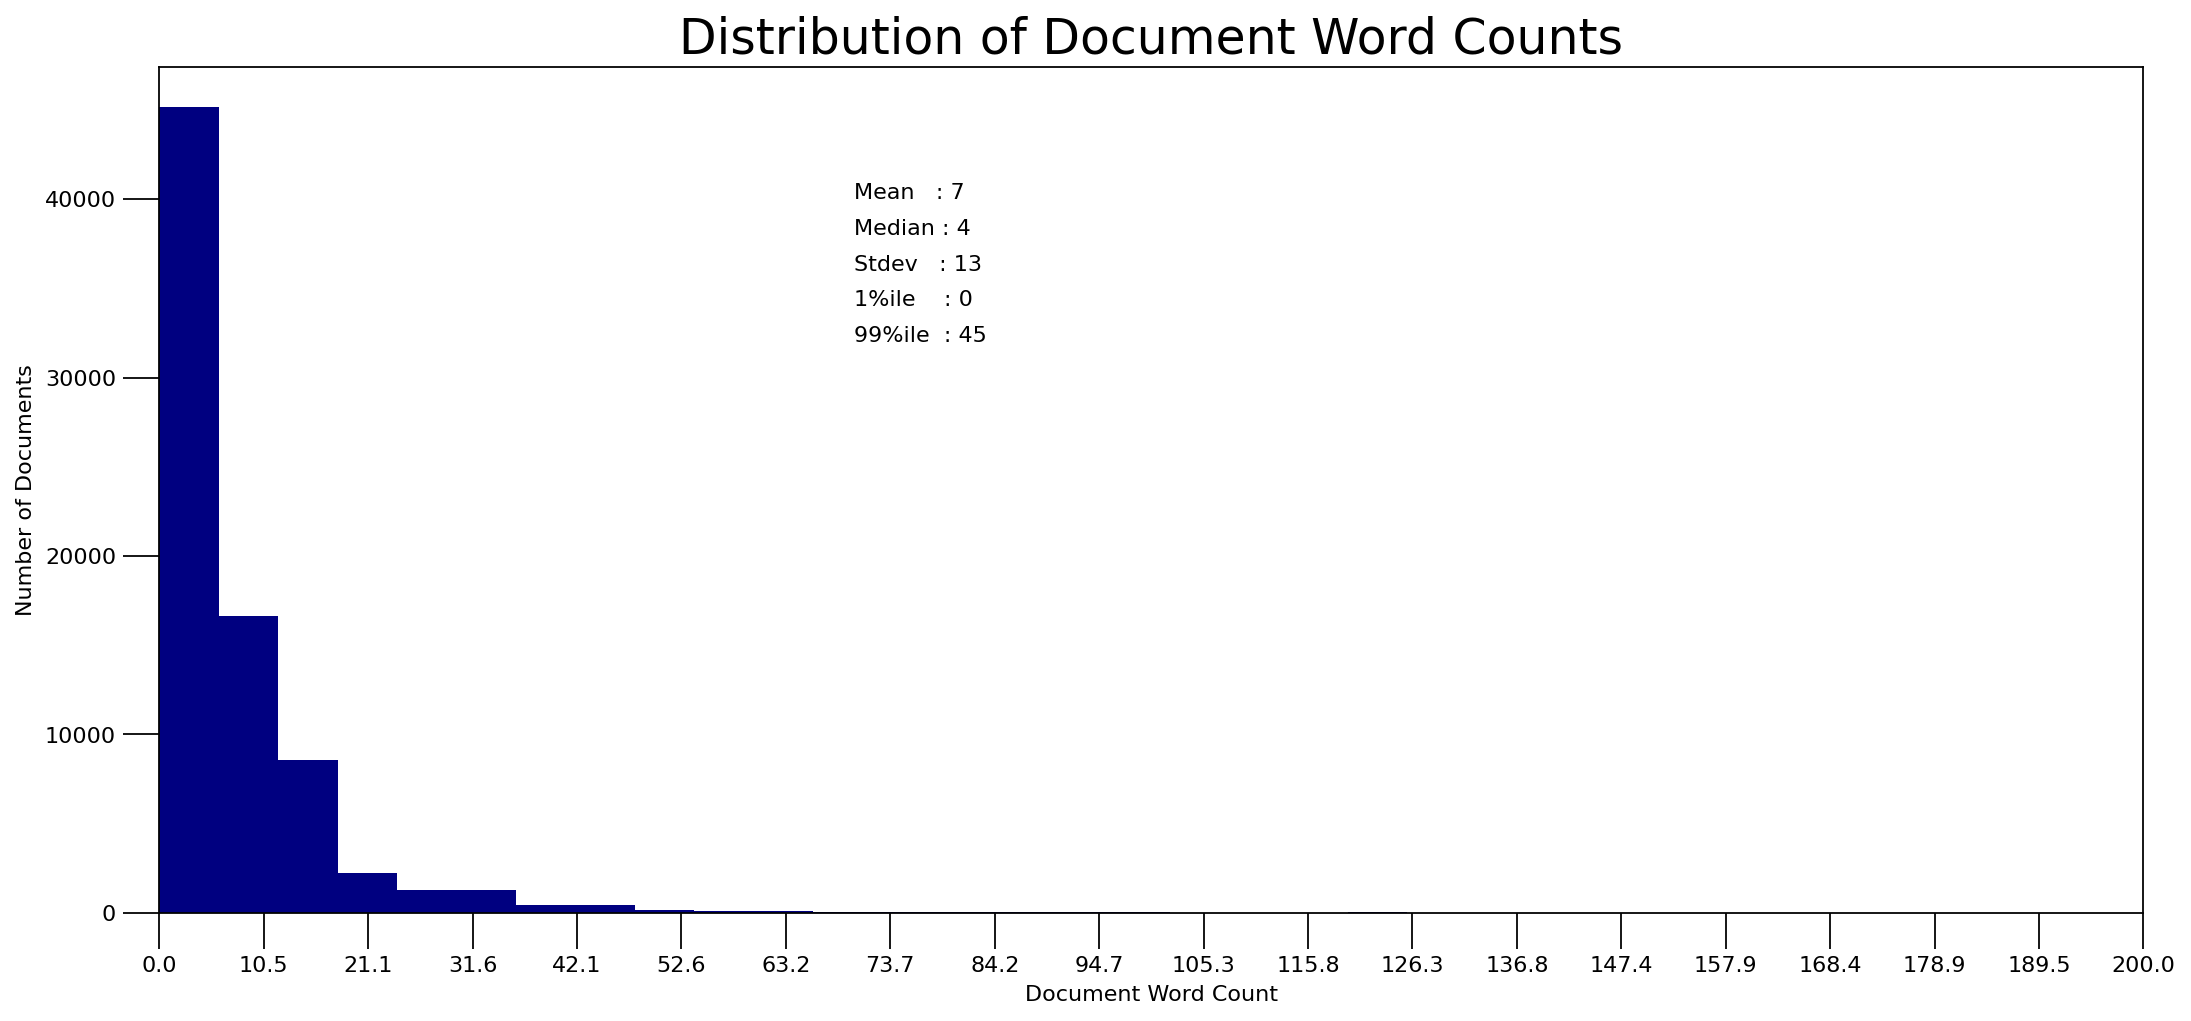

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(70, 40000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(70,  38000, "Median : " + str(round(np.median(doc_lens))))
plt.text(70,  36000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(70,  34000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(70,  32000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 125), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,200,20))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

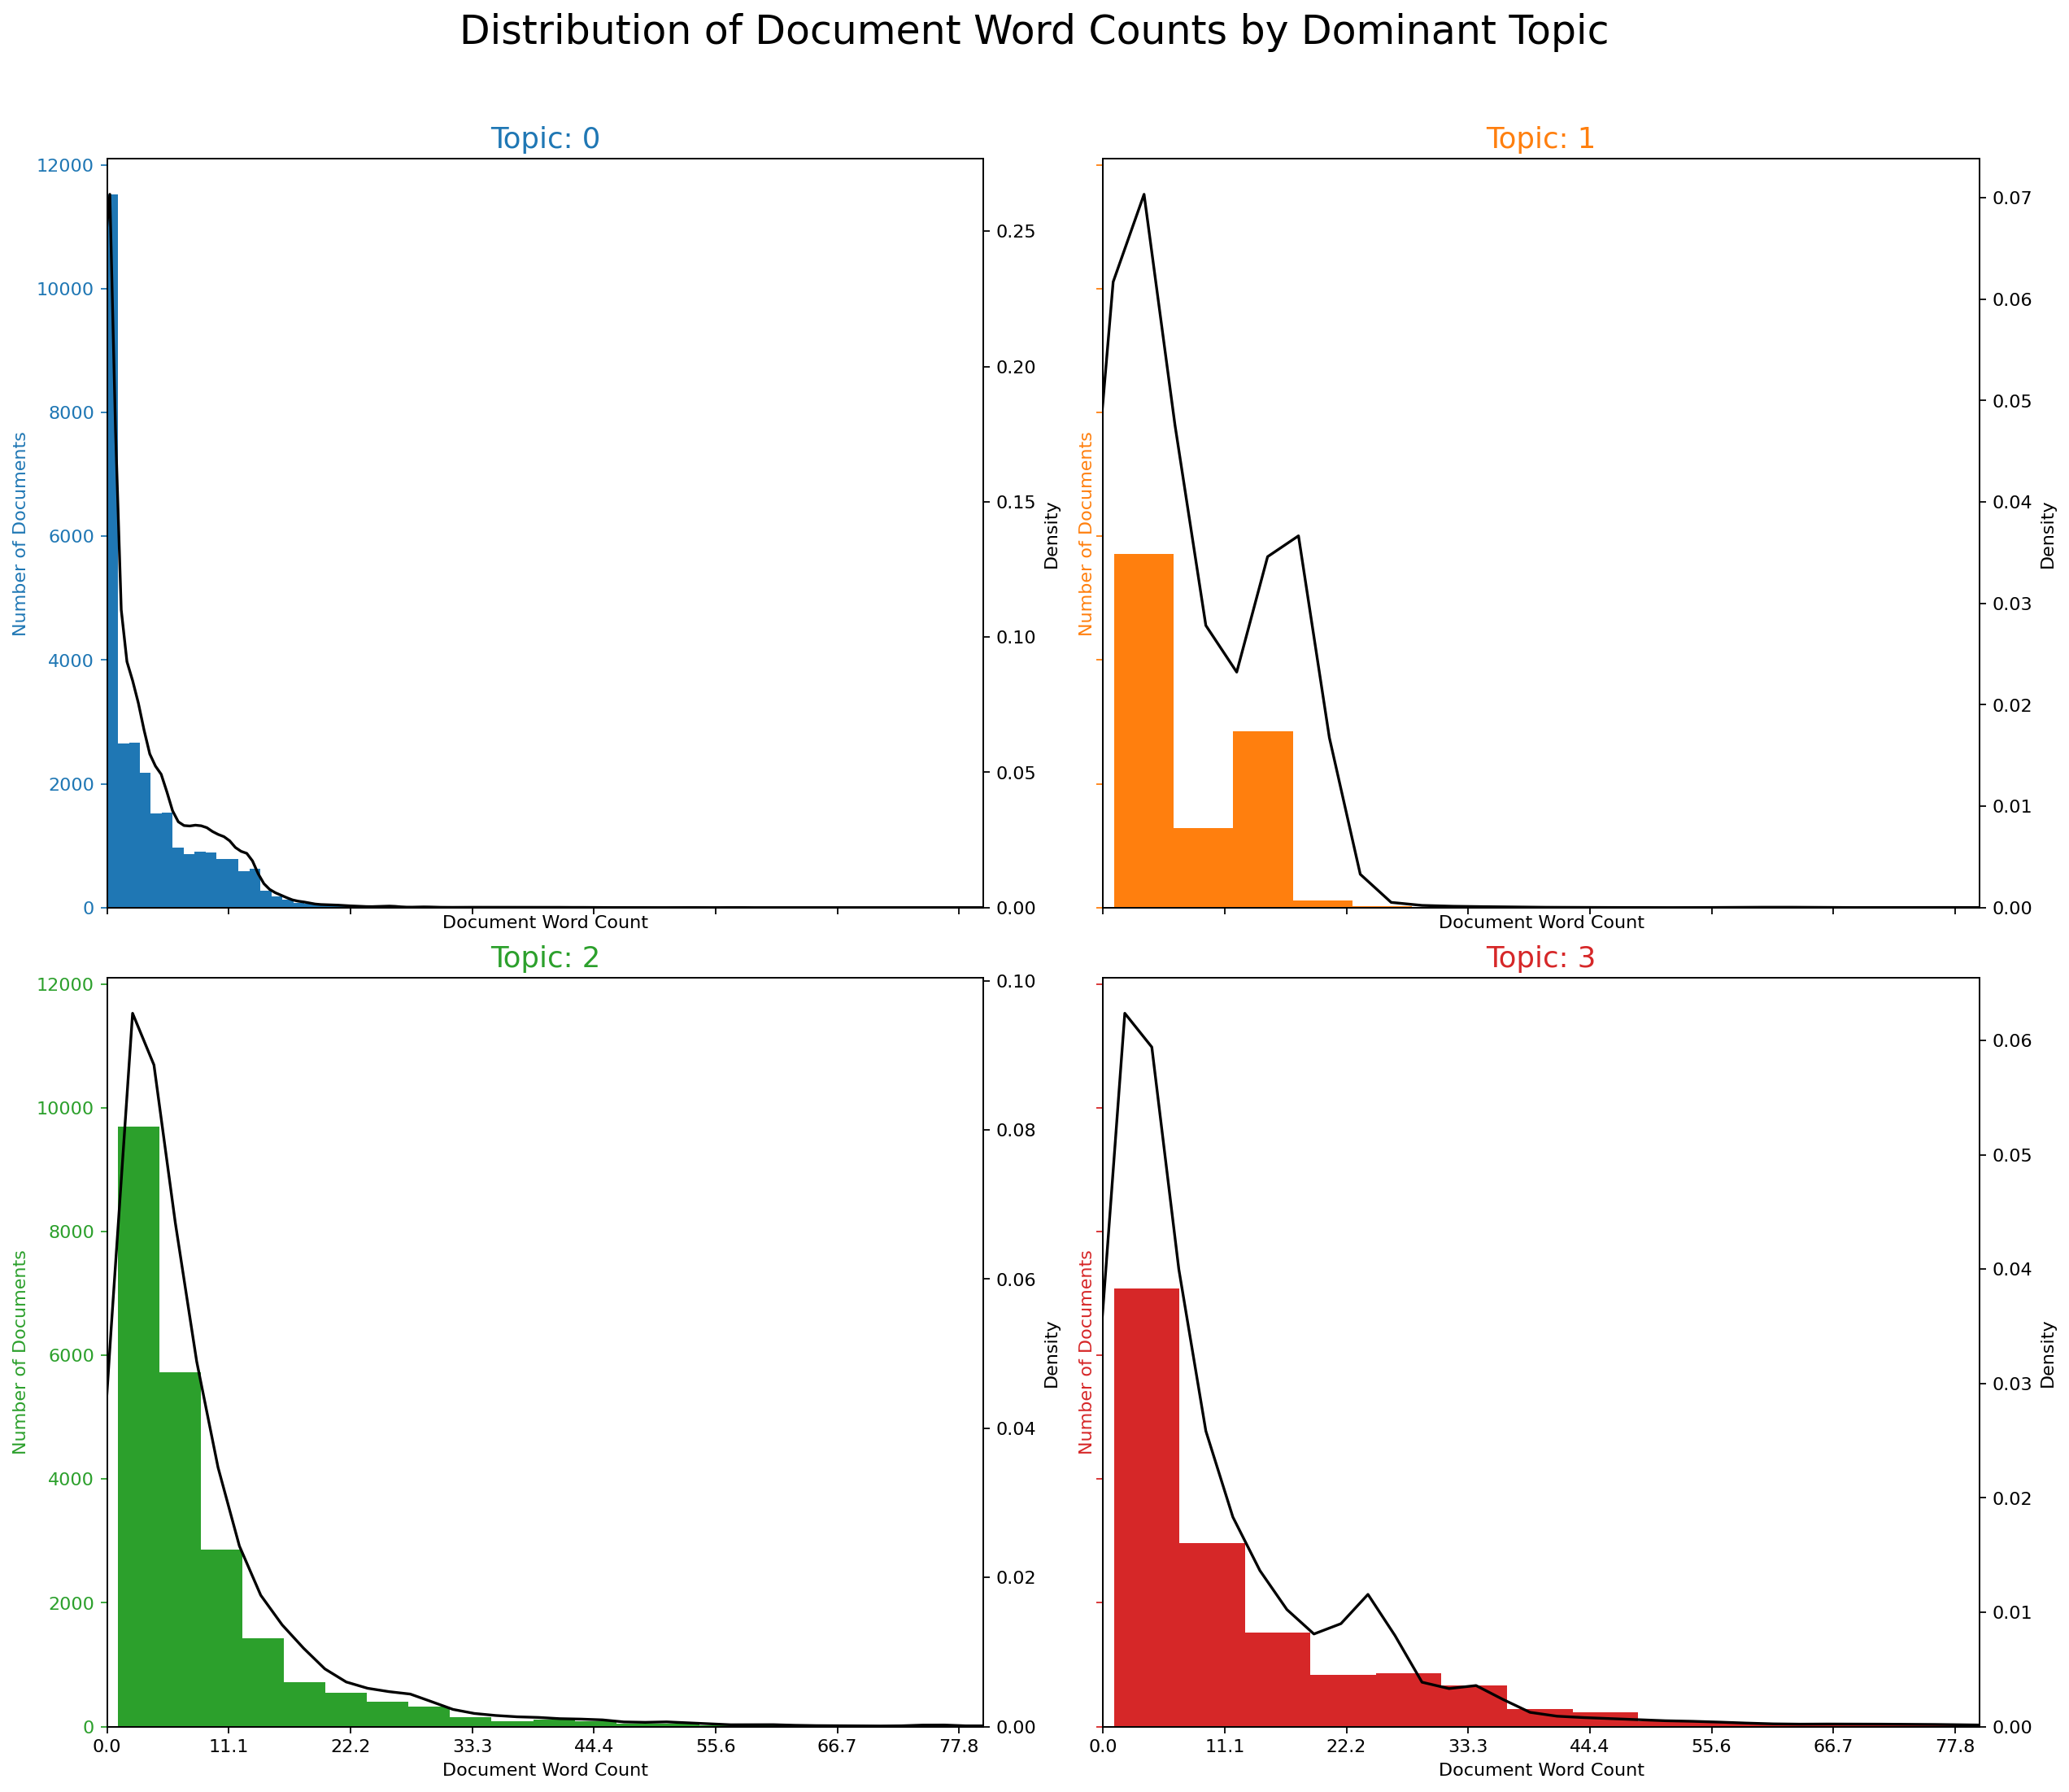

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 80), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,10))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# Word Clouds of Top N Keywords in Each Topic

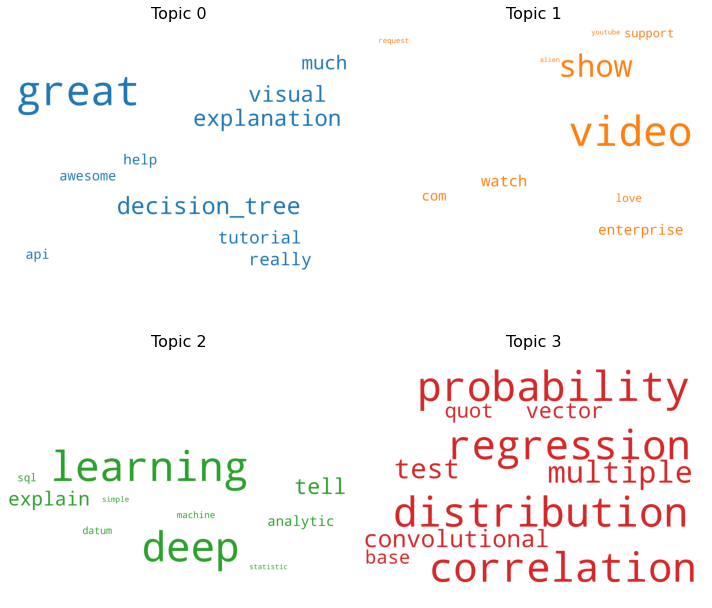

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords

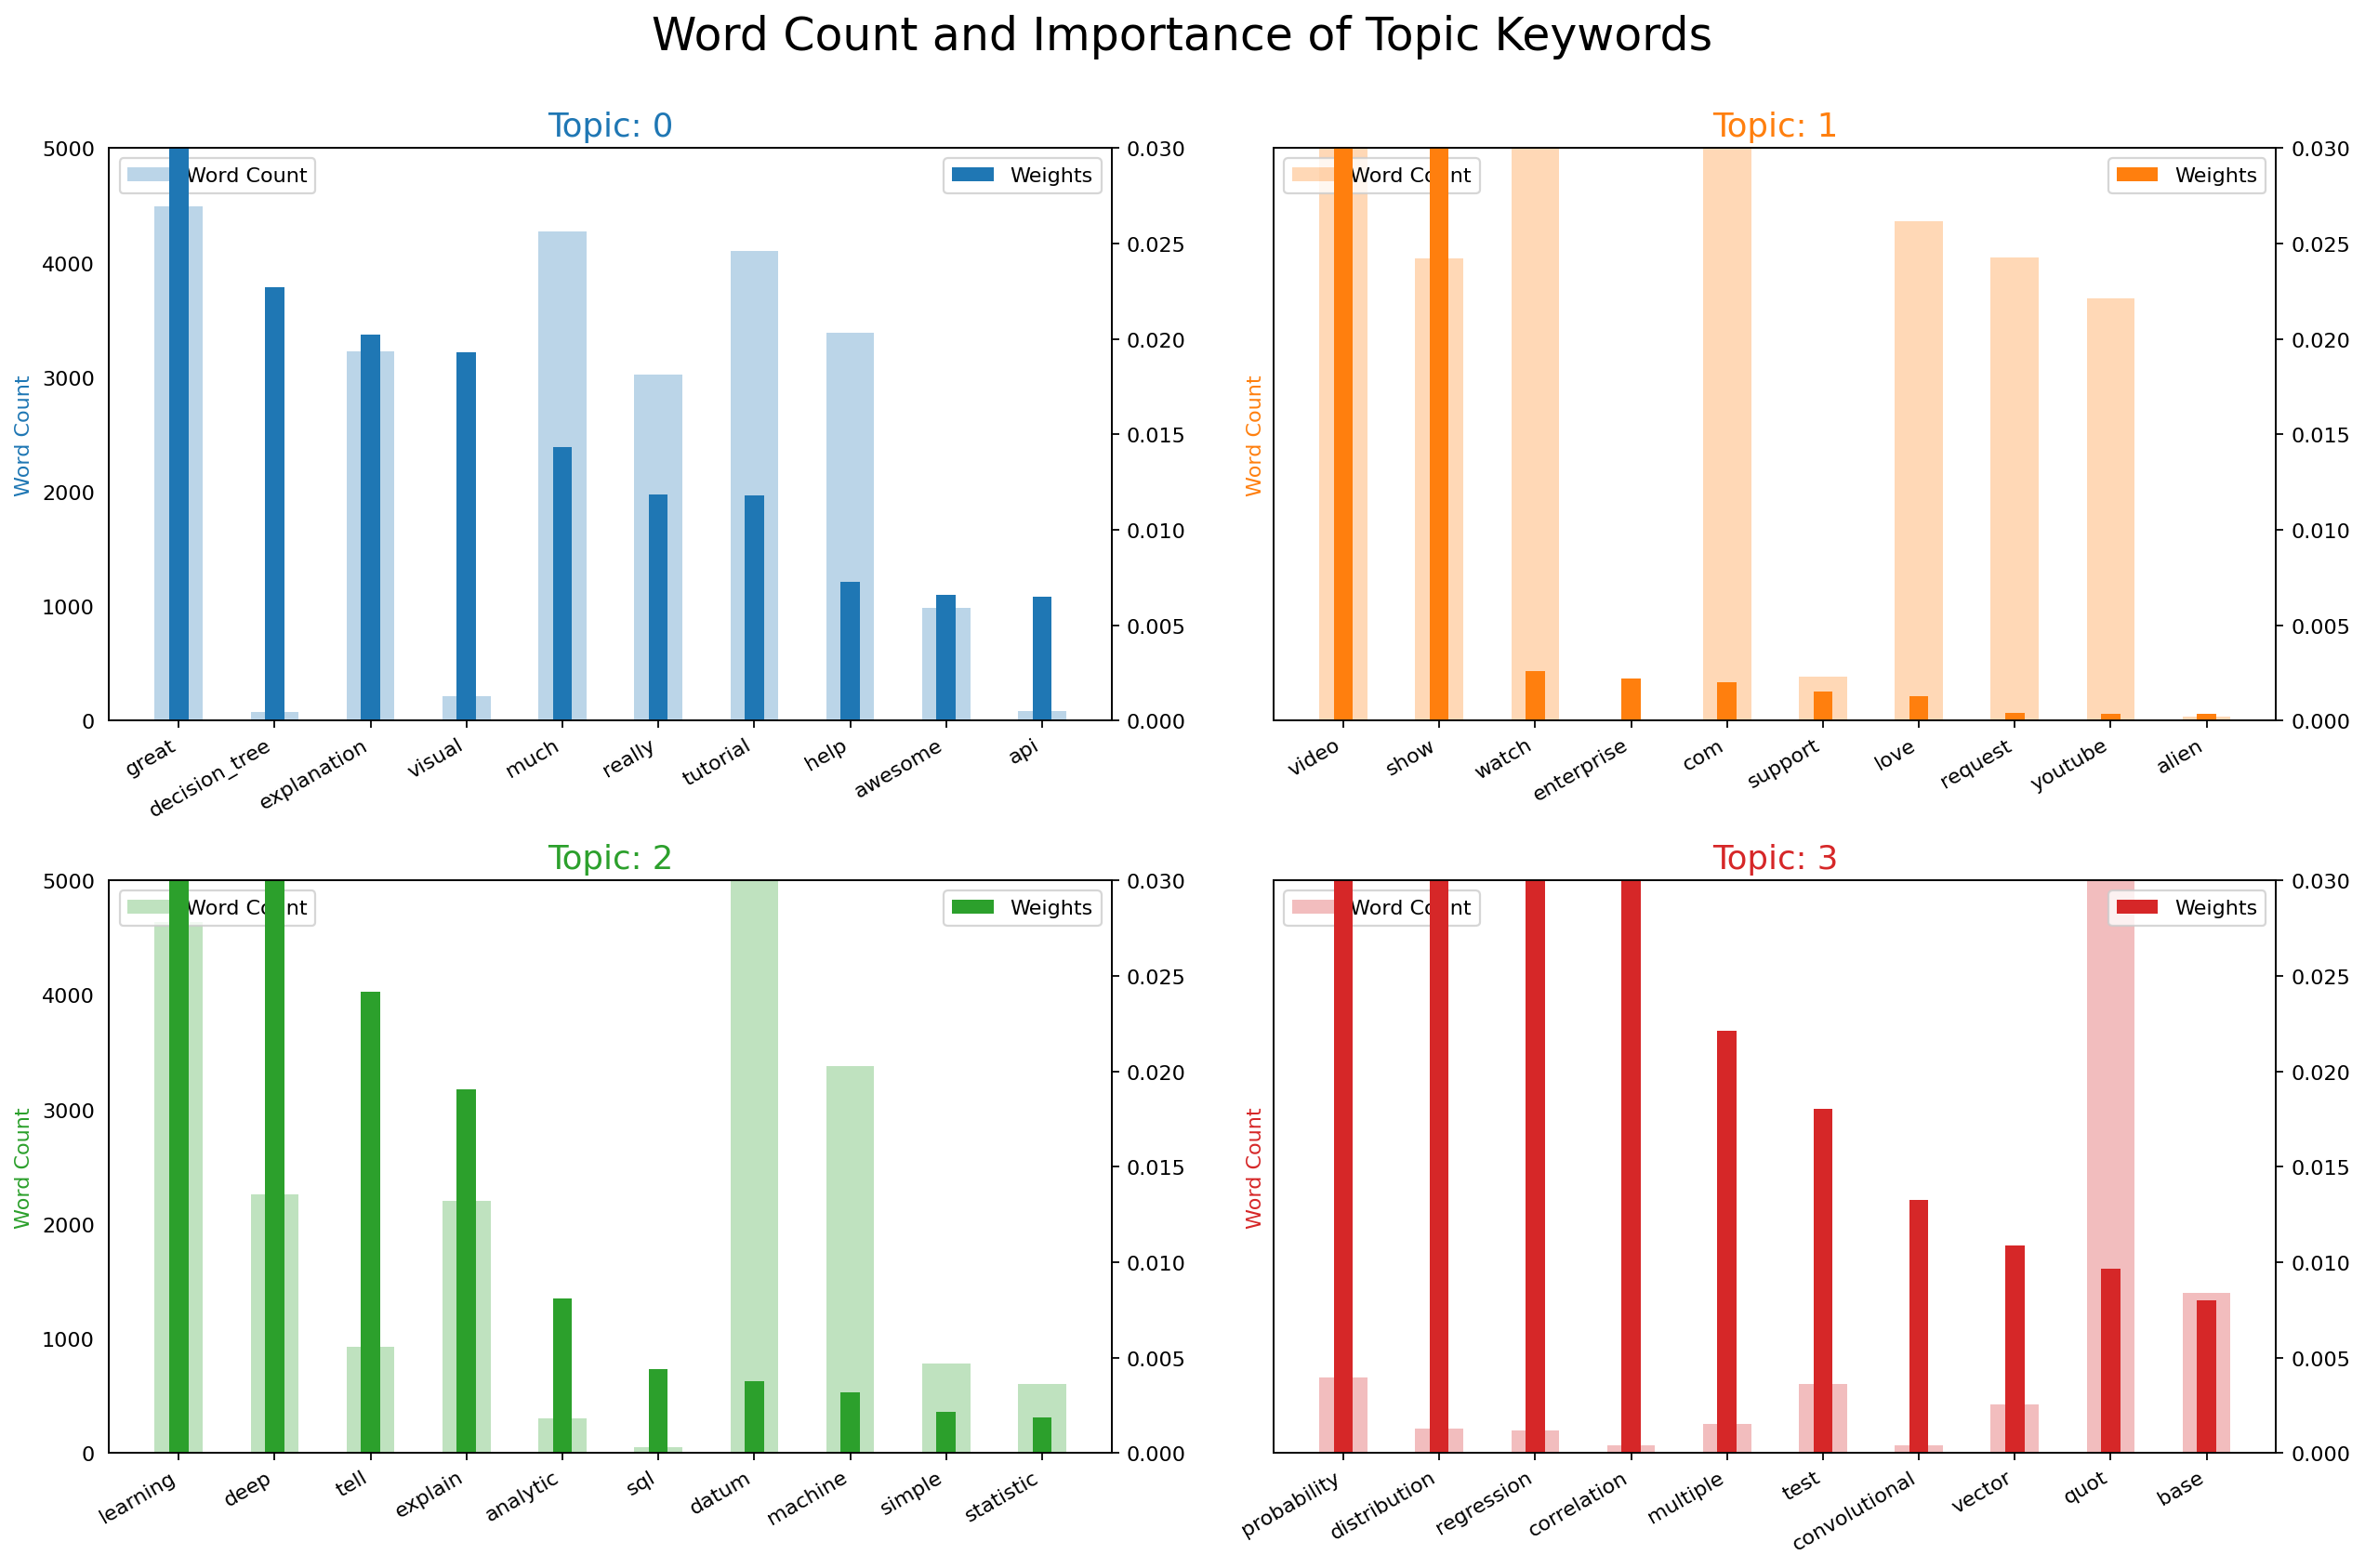

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 5000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# Sentence Chart Colored by Topic

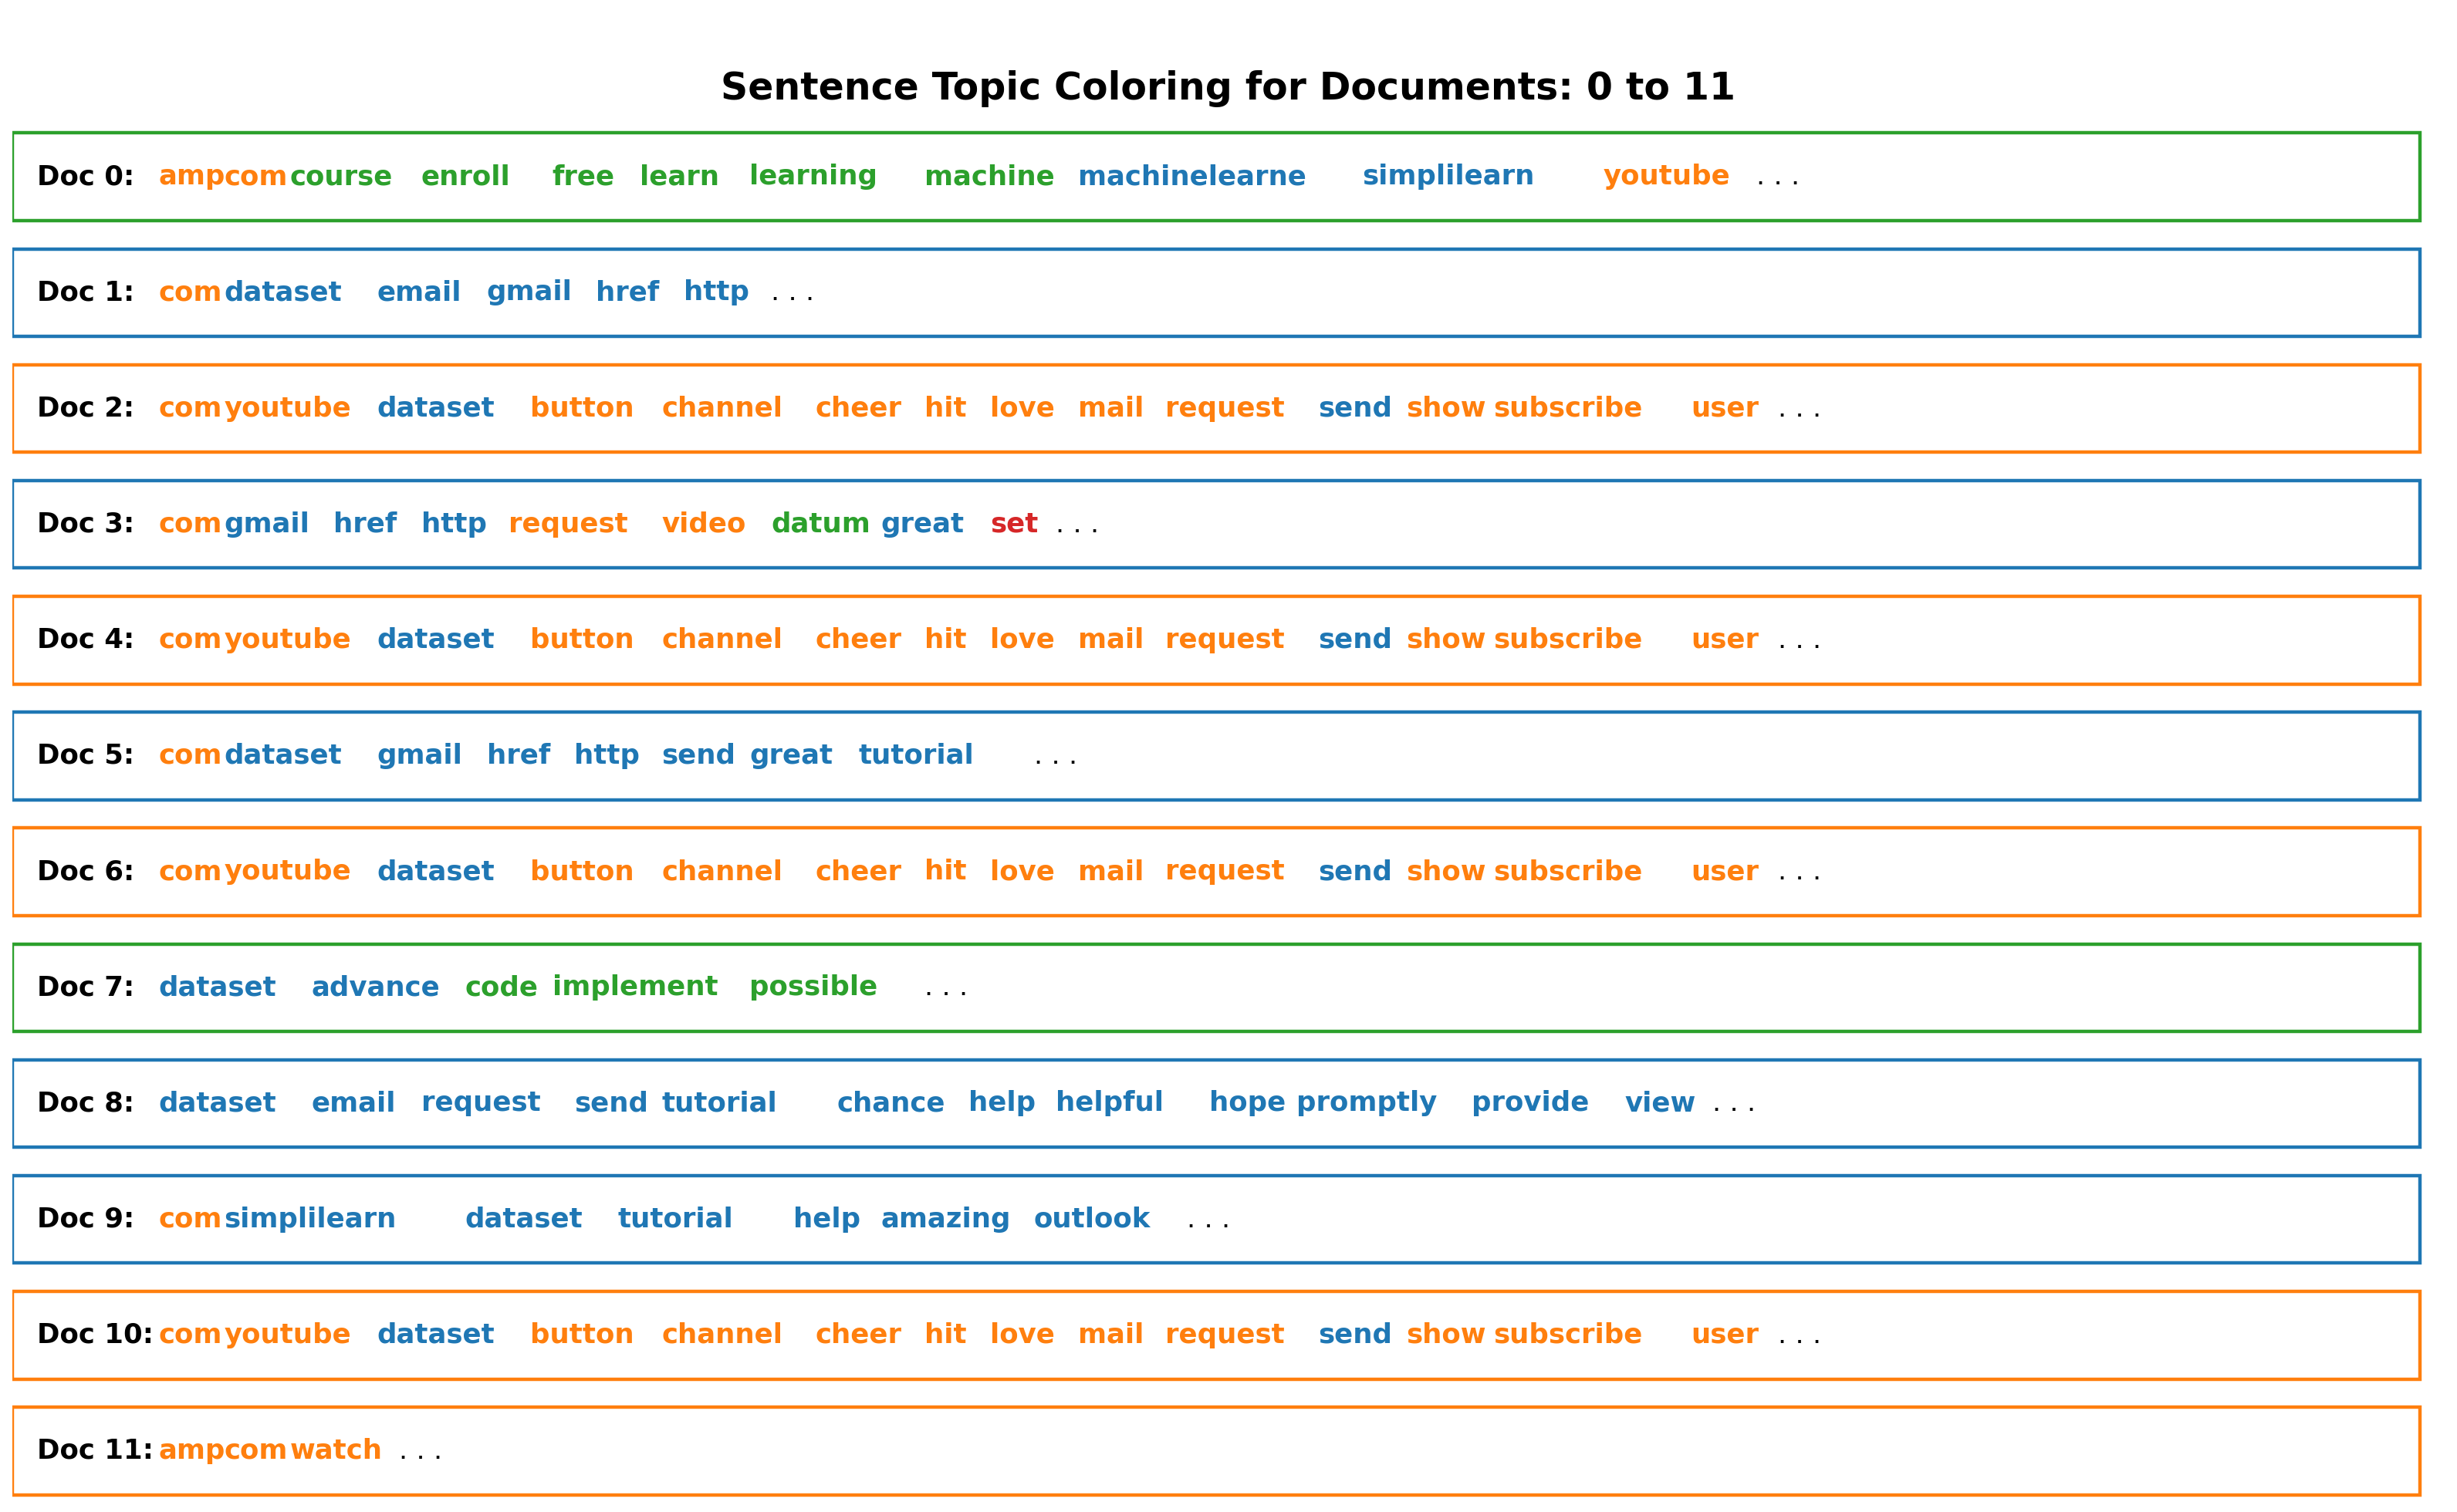

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

# What are the most discussed topics in the documents?

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

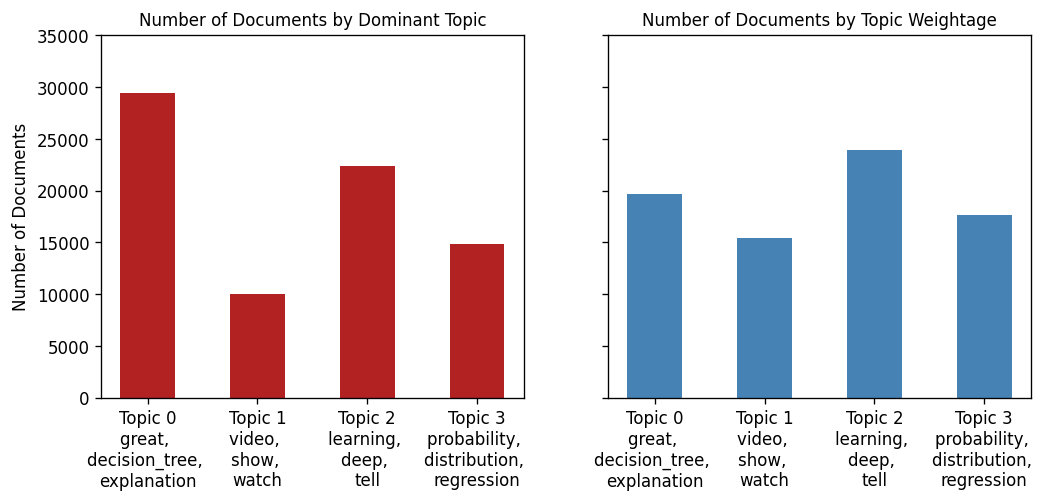

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 35000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

# t-SNE Clustering Chart

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 63674 samples in 0.058s...
[t-SNE] Computed neighbors for 63674 samples in 1.583s...
[t-SNE] Computed conditional probabilities for sample 1000 / 63674
[t-SNE] Computed conditional probabilities for sample 2000 / 63674
[t-SNE] Computed conditional probabilities for sample 3000 / 63674
[t-SNE] Computed conditional probabilities for sample 4000 / 63674
[t-SNE] Computed conditional probabilities for sample 5000 / 63674
[t-SNE] Computed conditional probabilities for sample 6000 / 63674
[t-SNE] Computed conditional probabilities for sample 7000 / 63674
[t-SNE] Computed conditional probabilities for sample 8000 / 63674
[t-SNE] Computed conditional probabilities for sample 9000 / 63674
[t-SNE] Computed conditional probabilities for sample 10000 / 63674
[t-SNE] Computed conditional probabilities for sample 11000 / 63674
[t-SNE] Computed conditional probabilities for sample 12000 / 63674
[t-SNE] Computed conditional probabilities for sam

# Save the model

In [ ]:
df.to_pickle('/content/drive/MyDrive/YouTube-Project/topic-modeling-gensim.pkl')